# Miranda's Gifts - Inventory Planning Tool

In [1]:
# import necessary libraries and files

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
from IPython.display import display


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
csv_file = 'sales_history.csv'

# bring in a copy of the data for use with graphs
graph_df = pd.read_csv(csv_file)

# bring in a copy of data for use with ML algorithm
sales_df = pd.read_csv(csv_file)

# the maximum units sold in any one month is needed for consistency among vizulaizations
y_max = 50 # todo... sales_df.to_numpy().max() + 5

## Sales History
Use the following drop down menu to select a year and view the sales history for that year.

In [3]:
## build single year graph ##

def sort_year(Year):
    df = graph_df.loc[graph_df['year'] == Year]
    
    sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.2)
    
    ax = sns.lineplot(data=df.iloc[:, 2:], dashes=False).set(
        title=f"Units Sold Per Month in {Year} for All Items",
        xlabel="Month", ylabel="Units Sold")
    
    plt.legend(loc='upper left', title="Item Number")
    plt.ylim(0, y_max);

year_list = np.unique(graph_df['year'])

widgets.interact(sort_year, Year=year_list);

interactive(children=(Dropdown(description='Year', options=(2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 20…

# Individual Item Information
Use the two boxes below to select an item and a year. Exact montly unit sales for the selected item throughout the selected year will be shown.

In [4]:
## build single item/year graph ##

year_list = np.unique(graph_df['year'])
item_list = graph_df.columns.tolist()[2::]

Year = widgets.Dropdown(options = year_list)
Item = widgets.Dropdown(options = item_list)
ui = widgets.HBox([Item, Year])

def sort_year_item(Year, Item):
    df = graph_df[["year", "month", Item]].loc[graph_df['year'] == Year]
    
    sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.2)
    
    ax = sns.barplot(x="month", y=Item, data=df)
    ax.bar_label(ax.containers[0])
    ax.set(
        title=f"Units Sold Per Month in {Year} for Item # {Item}",
        xlabel="Month", ylabel="Units Sold")
    plt.ylim(0, y_max);
    

out = widgets.interactive_output(sort_year_item, {'Item' : Item, 'Year' : Year})

display(ui, out)

Output()

# Sales Prediction
The following chart shows the projected sales for next month, as well as the sales history from last month.
It will update automatically as data is added the .csv file.

In [5]:
## prepare the sales_df data ##

# convert month and year columns into one date column, then move it to the leftmost column
sales_df["date"] = sales_df['month'] +"_"+ sales_df['year'].astype(str)
move = sales_df.pop("date") # holds the date column so it can be moved
sales_df.insert(0, "date", move)
sales_df.drop(["month", "year"], axis=1, inplace=True)

In [6]:
## methods for ml algorithm ##

# transform data into supervised learning
def build_item_df(data, item, months):
    df = pd.DataFrame()
    df["this_month"] = data[[str(item)]].copy(deep=True)
    
    # build sales history based on number of previous months
    for i in range (1, months + 1):
        col_name = str(i) + "_months_ago"
        df[col_name] = df["this_month"].shift(i)
    
    df.dropna(inplace=True)
    df = df.iloc[:, ::-1]
    
    return df

# train and test a model, then return the score
def test_model(data, item, months):
    np.random.seed(11)
    
    # bring in data
    supervised_data = build_item_df(data, item, months)    
    
    X = supervised_data.iloc[:,:-1] # final column removed
    y = supervised_data.iloc[:,-1:].to_numpy().ravel() # final column only

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # instantiate and fit the model
    model = RandomForestRegressor(n_estimators=100, max_depth=20)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    #check the score and mae of the model
    mae = mean_absolute_error(y_test, y_preds)
    
    return mae

# make predictions for each item, for upcoming month, and store in an array
def make_preds(data, months):
    preds = []
    item_qty = len(data.columns) - 1 # subract 1 to account for date column

    i=1
    while i <= item_qty:
        # print(item_qty - i) # print i if time remaining is wanted
        supervised_data = build_item_df(data, i, months)

        # prepare new data from supervised_data, last column is NaN but will be sliced off
        new_data = pd.DataFrame(supervised_data.iloc[-1]).transpose().shift(-1, axis="columns")
        
        # adjust data further for fitting
        model_data_X = supervised_data.iloc[:,:-1] # final column removed
        model_data_y = supervised_data.iloc[:,-1:].to_numpy().ravel() # final column only
        model_data_new = new_data.iloc[:,:-1] # final row shifted left with final column (NaN) removed

        # fit model to data
        model = RandomForestRegressor(n_estimators=100, max_depth=20)
        model.fit(model_data_X, model_data_y)
        
        # store prediction in array
        preds.append(model.predict(model_data_new))
        
        # do not forget to increment i :)
        i += 1
        
    preds = np.concatenate(preds, axis=None)
    return preds

In [7]:
# test_model(sales_df, 1, 25) # hide test results unless testing is occuring

In [8]:
## make prediction ##

# run prediction function, using the last 12 months as features
preds = make_preds(sales_df, 12)

In [9]:
## build prediction df for display

preds_df = pd.DataFrame()

items = list(sales_df.columns.values)
items.pop(0)

# store the last month's sales for use in the chart below and in the prediction comparison
last_month_sales = list(sales_df.iloc[-1])
last_month_name = last_month_sales[0]
last_month_sales.pop(0)

preds_df["Item Number"] = items
preds_df[last_month_name + " Sales"] = last_month_sales
preds_df["Next Month Projected"] = preds

preds_df.style.hide(axis='index').format(precision=2)

Item Number,December_2022 Sales,Next Month Projected
1,32,31.01
2,36,21.89
3,25,26.94
4,27,17.62
5,40,26.58
6,33,22.71
7,17,18.16
8,38,24.62
9,32,24.16
10,36,27.92


# Sales Prediction Comparison
The chart below displays the actual sales along side the projected sales. Note also the Mean Absolute Error in the title, which gives an overall indication of the accuracy of the predictions. An acceptable MAE is less than or equal to 6.

In [10]:
# copy the sales_df to a new dataframe
last_df = sales_df.copy()
last_df = last_df[:-1] # remove the last month's sales (this data was previously stored in last_month_sales)

In [11]:
# get the predictions from last month by running the prediction function
# the predictions are at this time not stored (future improvement)
last_preds = make_preds(last_df, 12)

In [12]:
# build dataframe for the line graph

last_preds_df = pd.DataFrame()
last_preds_df["Item Number"] = items
last_preds_df[last_month_name + " Sales"] = last_month_sales
last_preds_df[last_month_name + " Projected"] = last_preds


mae = mean_absolute_error(last_month_sales, last_preds)

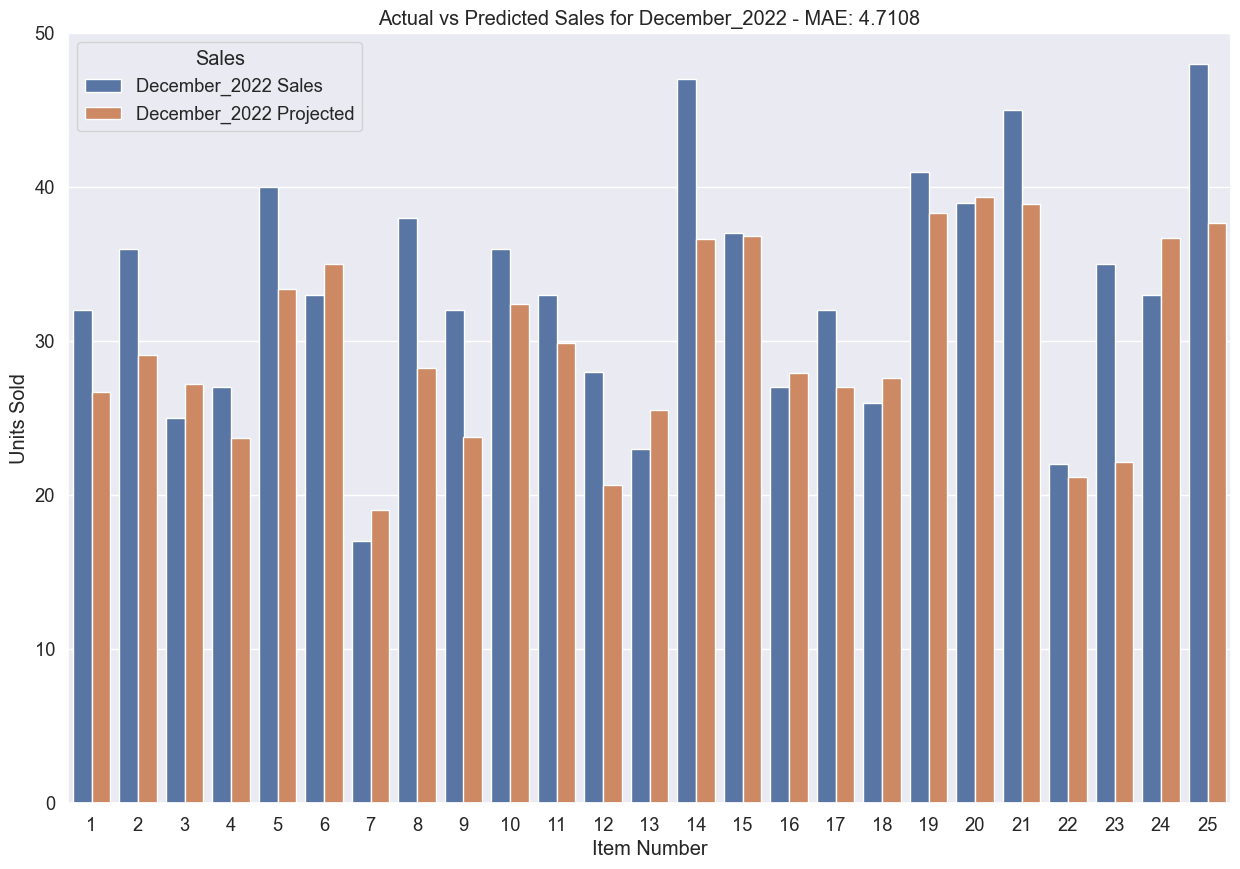

In [13]:
# build the line graph from the dataframe

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.2)

ax = sns.barplot(data=last_preds_df.melt(id_vars='Item Number', value_name='Units', var_name='Sales'),
    x="Item Number", y="Units", hue="Sales").set(
    title=f"Actual vs Predicted Sales for {last_month_name} - MAE: {mae}",
    xlabel="Item Number", ylabel="Units Sold")

plt.ylim(0, y_max);